## Company Bankruptcy Prediction

### Context

The data were collected from the Taiwan Economic Journal for the years 1999 to 2009. Company bankruptcy was defined based on the business regulations of the Taiwan Stock Exchange.

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('once')
warnings.simplefilter("ignore")

In [2]:
data = pd.read_csv('data.csv')
data.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,operating gross margin,realized sales gross margin,operating profit rate,tax Pre-net interest rate,after-tax net interest rate,non-industry income and expenditure/revenue,...,net income to total assets,total assets to GNP price,No-credit interval,Gross profit to Sales,Net income to stockholder's Equity,liability to equity,Degree of financial leverage (DFL),Interest coverage ratio( Interest expense to EBIT ),one if net income was negative for the last two year zero otherwise,equity to liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [3]:
Y = data['Bankrupt?']
data = data.drop(['Bankrupt?'], axis=1)

In [4]:
data.isnull().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0], dtype=int64)

# 1 Feature Selection

## 1.1 Remove too low variance

In [5]:
data_mean = np.mean(data, axis=0)

variance = np.var(data/data_mean, axis=0)
var_df = pd.DataFrame(variance,columns=['variance'])
var_df.sort_values(by='variance').style.background_gradient(sns.light_palette('green', as_cmap=True))

,variance
one if net income was negative for the last two year zero otherwise,0.000000
operating profit growth rate,0.000161
operating profit rate,0.000170
Cash flow to Sales,0.000193
working capitcal turnover rate,0.000227
working capital/equity,0.000252
tax Pre-net interest rate,0.000261
continuous interest rate (after tax),0.000263
after-tax net interest rate,0.000283
Net income to stockholder's Equity,0.000299


In [6]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(5.0).fit(data/data_mean)

vt_transform = vt.transform(data/data_mean)

In [7]:
high_var_cols = data.columns[vt.get_support()]
low_var_cols = data.columns[~vt.get_support()]

print("Removed cols :",len(low_var_cols))
print("Remaining cols :",len(high_var_cols))

Removed cols : 74
Remaining cols : 21


## 1.2 Inspect Correlation

In [8]:
corr_mat = np.corrcoef(vt_transform, rowvar=False)
corr_mat = pd.DataFrame(corr_mat)

corr_mat.style.background_gradient(sns.light_palette('blue', as_cmap=True))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,1.000000,-0.003904,0.013614,-0.001840,-0.005201,-0.003984,0.002245,-0.006983,0.016496,-0.036213,-0.002586,0.024254,0.055143,-0.011063,0.011240,0.006090,-0.000202,-0.009759,-0.001840,0.033571,-0.007519
1,-0.003904,1.000000,-0.000353,-0.000311,-0.000880,0.029592,0.128149,0.264346,-0.000985,-0.010462,0.275742,-0.000982,-0.000538,-0.001871,0.037494,-0.002441,-0.000558,-0.010894,-0.000311,-0.000881,-0.001272
2,0.013614,-0.000353,1.000000,-0.000166,-0.000470,-0.000360,-0.001914,-0.000631,-0.000526,0.036004,-0.000234,-0.000524,0.075915,-0.000999,-0.001316,-0.001303,-0.000709,0.008879,-0.000166,0.400342,-0.000679
3,-0.001840,-0.000311,-0.000166,1.000000,-0.000415,-0.000318,0.000118,-0.000557,-0.000464,-0.004931,-0.000206,-0.000463,-0.000254,-0.000882,-0.001161,-0.001150,0.003411,-0.002240,-0.000147,-0.000415,-0.000599
4,-0.005201,-0.000880,-0.000470,-0.000415,1.000000,-0.000898,0.001013,-0.001574,0.016026,0.001797,-0.000583,-0.001309,-0.000717,0.151987,-0.003283,-0.003252,-0.000314,-0.014514,-0.000415,-0.001173,-0.001694
5,-0.003984,0.029592,-0.000360,-0.000318,-0.000898,1.000000,0.030256,0.008627,-0.001005,0.016062,-0.000446,-0.001002,-0.000549,-0.001910,-0.002515,-0.002491,-0.000725,-0.011118,-0.000318,-0.000899,-0.001298
6,0.002245,0.128149,-0.001914,0.000118,0.001013,0.030256,1.000000,0.007167,0.023772,-0.048631,-0.002326,0.342925,-0.001740,0.013864,0.000367,-0.003992,0.052586,0.015572,0.393705,-0.005833,-0.003589
7,-0.006983,0.264346,-0.000631,-0.000557,-0.001574,0.008627,0.007167,1.000000,-0.001762,-0.001709,0.032398,-0.001757,-0.000962,0.036912,0.048829,-0.001859,-0.000684,-0.019486,-0.000557,-0.001575,0.113731
8,0.016496,-0.000985,-0.000526,-0.000464,0.016026,-0.001005,0.023772,-0.001762,1.000000,-0.013746,-0.000653,-0.000539,-0.000803,0.018409,-0.003676,-0.003641,0.459146,0.021400,0.006008,-0.001314,-0.001897
9,-0.036213,-0.010462,0.036004,-0.004931,0.001797,0.016062,-0.048631,-0.001709,-0.013746,1.000000,-0.006700,-0.015561,-0.007697,0.017976,0.011197,-0.026209,-0.006679,-0.042103,-0.004931,0.004789,-0.013477


## 1.3 Recursive Feature Elimination <br>
Using Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

rfe = RFE(estimator = RandomForestClassifier(n_estimators=300, class_weight={0:1,1:2}), n_features_to_select=18, verbose=1).fit(vt_transform, Y.values)

Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.


In [10]:
vt_transform_rfe = rfe.transform(vt_transform)
vt_transform_rfe.shape

(6819, 18)

# 2 Predictive models

This data is **Highly imbalanced class** because not so many companies are bankrupted. <br>
Thus, we need to concern very much about **Recall** score because we don't want to misclassified the bankrupted.<br>

"This company is bankrupted, but we predicted that this company is safe" -> We don't want this to happen.

In [11]:
Y.value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

## 2.1 Build the models

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import xgboost  

X_train, X_test,y_train, y_test = train_test_split(vt_transform_rfe, Y.values, test_size=0.25, stratify=Y.values)
scaler = StandardScaler().fit(X_train)

models = dict()

models['Random Forest'] = RandomForestClassifier(n_estimators=300, class_weight={0:1,1:3})
models['Logreg'] = LogisticRegression(penalty='elasticnet',  class_weight={0:1,1:3}, solver='saga', l1_ratio=0.7)
models['GradientBoost'] = GradientBoostingClassifier(n_estimators=300)
models['XGBoost'] = xgboost.XGBClassifier(objective = 'binary:logistic')

for model in models:
    if model == 'Logreg':
        train = scaler.transform(train)
    else:
        train = X_train
    models[model].fit(train, y_train)
    print(model + ' : fit')


Random Forest : fit
Logreg : fit
GradientBoost : fit
[17:15:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost : fit


## 2.2 Performance in train set

In [13]:
for x in models:

    if x == 'Logreg':
        train = scaler.transform(X_train)
    else:
        train = X_train
        
    print('------------------------'+x+'------------------------')
    model = models[x]
    y_train_pred = model.predict(train)
    arg_train = {'y_true':y_train, 'y_pred':y_train_pred}
    print(confusion_matrix(**arg_train))
    print(classification_report(**arg_train))
    

------------------------Random Forest------------------------
[[4949    0]
 [  89   76]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4949
           1       1.00      0.46      0.63       165

    accuracy                           0.98      5114
   macro avg       0.99      0.73      0.81      5114
weighted avg       0.98      0.98      0.98      5114

------------------------Logreg------------------------
[[4908   41]
 [ 150   15]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4949
           1       0.27      0.09      0.14       165

    accuracy                           0.96      5114
   macro avg       0.62      0.54      0.56      5114
weighted avg       0.95      0.96      0.95      5114

------------------------GradientBoost------------------------
[[4949    0]
 [  64  101]]
              precision    recall  f1-score   support

           0       0.99      1.

We see that XGBoost has done a very good job!!

## 2.3 Performance in test set

In [14]:
for x in models:
    
    if x == 'Logreg':
        test = scaler.transform(X_test)
    else:
        test=X_test
    print('------------------------'+x+'------------------------')
    model = models[x]
    y_test_pred = model.predict(test)
    arg_test = {'y_true':y_test, 'y_pred':y_test_pred}
    print(confusion_matrix(**arg_test))
    print(classification_report(**arg_test))

------------------------Random Forest------------------------
[[1649    1]
 [  53    2]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1650
           1       0.67      0.04      0.07        55

    accuracy                           0.97      1705
   macro avg       0.82      0.52      0.53      1705
weighted avg       0.96      0.97      0.95      1705

------------------------Logreg------------------------
[[1643    7]
 [  50    5]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1650
           1       0.42      0.09      0.15        55

    accuracy                           0.97      1705
   macro avg       0.69      0.54      0.57      1705
weighted avg       0.95      0.97      0.96      1705

------------------------GradientBoost------------------------
[[1635   15]
 [  53    2]]
              precision    recall  f1-score   support

           0       0.97      0.

XGBoost have the greatest Recall !!

## 2.4 Take care of XGB

### Lower the probability threshold to improve Recall score

In [15]:
# Test set
model = models['XGBoost']
y_test_pred_prob = model.predict_proba(X_test)

y_test_pred_prob_lowerThres = y_test_pred_prob[:,1] > 0.1

arg_test = {'y_true':y_test, 'y_pred':y_test_pred_prob_lowerThres}
print("TEST\n")
print(confusion_matrix(**arg_test))
print(classification_report(**arg_test))


# Train set
y_train_pred_prob = model.predict_proba(X_train)

y_train_pred_prob_lowerThres = y_train_pred_prob[:,1] > 0.1

arg_train = {'y_true':y_train, 'y_pred':y_train_pred_prob_lowerThres}
print("TRAIN\n")
print(confusion_matrix(**arg_train))
print(classification_report(**arg_train))

TEST

[[1621   29]
 [  27   28]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1650
           1       0.49      0.51      0.50        55

    accuracy                           0.97      1705
   macro avg       0.74      0.75      0.74      1705
weighted avg       0.97      0.97      0.97      1705

TRAIN

[[4949    0]
 [   0  165]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4949
           1       1.00      1.00      1.00       165

    accuracy                           1.00      5114
   macro avg       1.00      1.00      1.00      5114
weighted avg       1.00      1.00      1.00      5114



In [16]:
rfe.ranking_ 

array([1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1])

### Cross validation score on Recall score

In [17]:
from sklearn.metrics import make_scorer, recall_score

recall_scorer = make_scorer(recall_score)
cv_score = cross_val_score(models['XGBoost'], X_train, y_train, cv=5, scoring=recall_scorer)

[17:15:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:15:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:15:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:15:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [18]:
print('cv_score :', cv_score)
print('mean :',cv_score.mean())

cv_score : [0.24242424 0.21212121 0.24242424 0.24242424 0.15151515]
mean : 0.2181818181818182


## 2.5 ROC curve

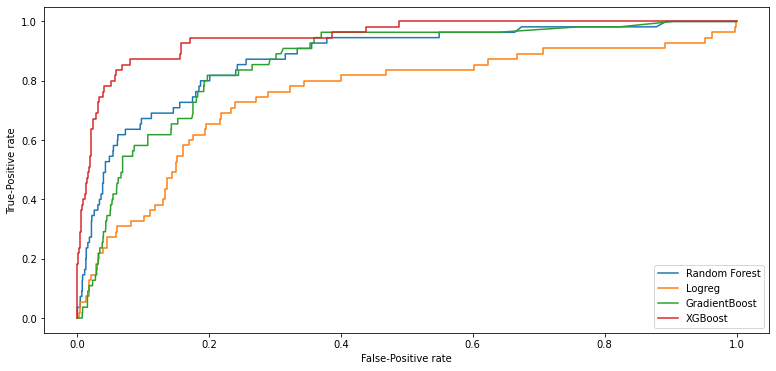

In [19]:
from sklearn.metrics import roc_curve

fig, ax = plt.subplots()
fig.set_size_inches(13,6)

for m in models:
    y_pred = models[m].predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred[:,1].ravel())
    plt.plot(fpr,tpr, label=m)
plt.xlabel('False-Positive rate')
plt.ylabel('True-Positive rate')
plt.legend()
plt.show()

## 2.6 Randomized search 

In [20]:
from sklearn.model_selection import RandomizedSearchCV

params = {'eta':[0.2,0.3,0.4],
         'max_depth':[5,6,7],
         'sampling_method':['uniform','gradient_based'],
         'lambda':[1,1.5],
         'alpha':[0,0.5],
         }

search = RandomizedSearchCV(estimator = models['XGBoost'], n_iter=50, scoring = recall_scorer, cv=5, verbose=1, param_distributions=params)

In [21]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[17:15:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:15:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:15:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:15:2

[17:15:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:15:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:15:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:15:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:16:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:16:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:16:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:17:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:17:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:17:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:17:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:17:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:17:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:17:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:17:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:18:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:18:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:18:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:18:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:18:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:18:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:18:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:18:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:18:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:18:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:18:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:18:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           gpu_id=-1, importance_type='gain',
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constraints='()',
                                           n_estimators=100, n_jobs=8,
                                           num_parallel_tree=1, random_state=0,
                                           reg_alpha=0, reg_lambda=1,
                                       

In [22]:
print("Best cv score :",search.best_score_)
print("Best params :",search.best_params_)

Best cv score : 0.2606060606060606
Best params : {'sampling_method': 'uniform', 'max_depth': 7, 'lambda': 1.5, 'eta': 0.2, 'alpha': 0}


We see that cv_score is improved.

In [23]:
models['XGB_searched'] = search.best_estimator_

model = models['XGB_searched']
test=X_test
print('TEST')
print('------------------------'+x+'------------------------')
y_test_pred = model.predict_proba(test)[:,1] > 0.1
arg_test = {'y_true':y_test, 'y_pred':y_test_pred}
print(confusion_matrix(**arg_test))
print(classification_report(**arg_test))


train = X_train
print("TRAIN")
print('------------------------'+x+'------------------------')
y_train_pred = model.predict_proba(train)[:,1] > 0.1
arg_train = {'y_true':y_train, 'y_pred':y_train_pred}
print(confusion_matrix(**arg_train))
print(classification_report(**arg_train))

TEST
------------------------XGBoost------------------------
[[1625   25]
 [  27   28]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1650
           1       0.53      0.51      0.52        55

    accuracy                           0.97      1705
   macro avg       0.76      0.75      0.75      1705
weighted avg       0.97      0.97      0.97      1705

TRAIN
------------------------XGBoost------------------------
[[4949    0]
 [   0  165]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4949
           1       1.00      1.00      1.00       165

    accuracy                           1.00      5114
   macro avg       1.00      1.00      1.00      5114
weighted avg       1.00      1.00      1.00      5114



Recall is also improved.